In [1]:
import cv2
import numpy as np
import argparse as ap
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [100,5]

Supplemental material for Lecture 9 on corner detection

In [2]:
"""
Input: img = HxWx1 image
       sigma = gaussian sigma value
       threshold = corner threshold to keep top % of corners

Output: List of corner tuples in (y,x,r) format, where r is the harmonic response
"""
def harris(img, sigma=1, threshold=0.01):
    """
    Slide 49 of the notes
    """
    height,width = img.shape[:2]
    corners = []

    #Perform some noise removal
    img = cv2.GaussianBlur(img, (5,5), 0)

    #Get the gradients
    dx = cv2.Sobel(img,cv2.CV_32F,1,0,ksize=1)
    dy = cv2.Sobel(img,cv2.CV_32F,0,1,ksize=1)
    
    #Calculate A,B,C of H 
    Ixx = dx**2
    Ixy = dx*dy 
    Iyy = dy**2
    
    print("Ixy", Ixy.min(), Ixy.max())
    
    #Apply w
    k = (int(sigma),int(sigma))
    Ixx = cv2.GaussianBlur(Ixx, k, 0)
    Ixy = cv2.GaussianBlur(Ixy, k, 0)
    Iyy = cv2.GaussianBlur(Iyy, k, 0)

    print("w*Ixy", Ixy.min(), Ixy.max())
   
    #Approximate the eignenvalues by finding the determinate and trace of H
    det = (Ixx * Iyy) - (Ixy**2)
    trace = Ixx + Iyy
    
    kappa = 0.04 #0.04-0.06
    R0 = det - kappa * trace**2 #Harris version
    R1 = det / trace #Szelinski, et al version
    R1 = np.nan_to_num(R1) #Handle the divide by zero by replacing nan with 0
    
    print("R0", R0.min(), R0.max())
    print("R1", R1.min(), R1.max())
    
    # Adaptive non-maximum suppression, keep the top 1% of values
    # and remove non-maximum points in a 3x3 neighbourhood
    corners = []
    for R in (R0,R1):
        corner_threshold = R.max() * threshold
        potential_corners = zip(*np.where((R > threshold) & (R > 10)))
    
        nms = list()
        for y,x in potential_corners:
            n = R[y-1:y+2, x-1:x+2] #I'm just being lazy

            if n.shape != (3,3): continue
            n[n < n.max()] = 0

            if R[y,x] > 0:
                nms.append([y,x])

        corners.append(nms)
    
    print(f"Found {len(corners[0])} Harris corners")
    print(f"Found {len(corners[1])} det/tr corners")
    return corners


In [3]:
def draw_corners(corners, img):
    img_harris = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img_szelinski = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    for i,c in enumerate(corners):
        for y,x in corners[0]:
            if i == 0:
                img_harris[y,x] = (255,0,0)
            else: 
                img_szelinski[y,x] = (255, 0, 0)

   
    """
    plt.subplot(1,3,1),plt.imshow(img)
    plt.title('Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(img_harris)
    plt.title('Harris'), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,3),plt.imshow(img_szelinski)
    plt.title('Szelinski'), plt.xticks([]), plt.yticks([])
    plt.show()
    """
    plt.title('Harris'); plt.imshow(img_harris)
    plt.show()
    plt.title('Det/trace'); plt.imshow(img_szelinski)
    plt.show()

Ixy -5928.0 7684.0
w*Ixy -4485.625 5554.6875
R0 -7610569.0 4038014.2
R1 0.0 940.4551


/home/memet/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Found 3819 Harris corners
Found 1936 det/tr corners


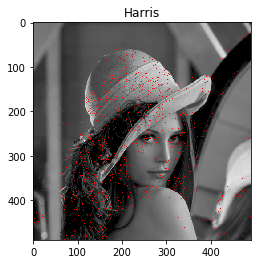

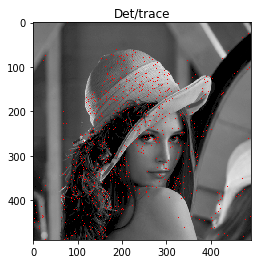

In [4]:
sigma = 3.
threshold = .01 
img = cv2.imread('images/lena.png', cv2.IMREAD_GRAYSCALE) 
corners = harris(img, sigma, threshold)
draw_corners(corners, img)
